In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.modules.utils import _pair
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

# Exploration

In [3]:
from baseline import Baseline

In [4]:
from genhebb import HebbianLayer, GenHebb

In [5]:
from sklearn.decomposition import PCA

In [6]:
import umap

### Investigate unsup layer weight matrix

In [1032]:
def load_model(plasticity='none', wta='none', unsup_epochs=50, sup_epochs=50, model_name=None):
    directory = 'saved_models/done-training'
    learning_rule = plasticity if wta == 'none' else f'{wta}_WTA_{plasticity}'
    if not model_name:
        model_name = f'genhebb-{learning_rule}-{unsup_epochs}_unsup_epochs-50_sup_epochs-0.001_unsup_lr-0.001_sup_lr-64_batch'
    path = f'{directory}/{model_name}.pt'
    if model_name.split('-')[0] == 'genhebb':
        model = GenHebb(28*28, 2000, 10, 1, plasticity, wta)
    else:
        model = Baseline(28*28, 2000, 10)
    model.load_state_dict(torch.load(path))
    return model

In [1025]:
def load_data(sample_size=1000):
    trainset = FastMNIST('./data', train=True, download=True)
    images, labels = next(iter(DataLoader(trainset, batch_size=sample_size, shuffle=True)))
    x = images.reshape(-1, 28*28)
    return x, labels

In [1026]:
def get_projection(x):
    pca = PCA(n_components=2)
    x_proj = pca.fit_transform(x)
    x_expl_var = pca.explained_variance_ratio_
    x_expl_var = [round(var, 3) for var in x_expl_var]
    return x_proj, x_expl_var

In [1027]:
def get_umap(x):
    reducer = umap.UMAP()
    x_umap = reducer.fit_transform(x)
    return x_umap

In [1141]:
# load original data and get projection
x, labels = load_data(sample_size=1000)
x_proj, x_expl_var = get_projection(x)
x_umap = get_umap(x)

In [1142]:
# get projections/umaps for all hebbian-learned embeddings
proj_embeddings = {}
umap_embeddings = {}
expl_vars = {}

for plasticity, wta in [('ojas_rule', 'hard')]:
    learning_rule = plasticity if wta == 'none' else f'{wta}_WTA_{plasticity}'
    for unsup_epochs, sup_epochs in [(1, 50), (10, 50)]:  # NOTE: add (50, 50), (100, 100)

        # get projected embedding
        model = load_model(plasticity, wta, unsup_epochs, sup_epochs)
        Wx = model.hebb(x).detach()
        # Wx_proj, Wx_expl_var = get_projection(Wx)
        Wx_umap = get_umap(Wx)

        # add to dicts
        key = f'{learning_rule}-{unsup_epochs}'
        # proj_embeddings[key] = Wx_proj
        umap_embeddings[key] = Wx_umap
        # expl_vars[key] = Wx_expl_var
        print(f'Done for {key}')

Done for hard_WTA_ojas_rule-1
Done for hard_WTA_ojas_rule-10


In [1143]:
# get baseline embeddings
baseline = load_model(model_name='baseline-50_epochs-0.001_lr-64_batch')
Wx = baseline.input(x).detach()
# baseline_proj, baseline_expl_var = get_projection(Wx)
baseline_umap = get_umap(Wx)

# get random_W embeddings
random_W = load_model(plasticity='random_W', model_name='genhebb-random_W-1_unsup_epochs-50_sup_epochs-0.001_unsup_lr-0.001_sup_lr-64_batch')
Wx = random_W.hebb(x).detach()
# random_W_proj, random_W_expl_var = get_projection(Wx)
random_W_umap = get_umap(Wx)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# plot for original and baselines
axes[0, 0].scatter(x_umap[:, 0], x_umap[:, 1], c=labels, cmap='Paired', s=5)
axes[0, 1].scatter(baseline_umap[:, 0], baseline_umap[:, 1], c=labels, cmap='Paired', s=5)
axes[0, 2].scatter(random_W_umap[:, 0], random_W_umap[:, 1], c=labels, cmap='Paired', s=5)
axes[0, 0].text(0.02, 0.95, 'original', transform=axes[0, 0].transAxes)
axes[0, 1].text(0.02, 0.95, 'baseline (BP)', transform=axes[0, 1].transAxes)
axes[0, 2].text(0.02, 0.95, 'random_W', transform=axes[0, 2].transAxes)
# axes[0, 3].axis('off')

# plot for Hebbian learning rules
for i, plasticity, wta in [(1, 'ojas_rule', 'hard')]:
    for j, unsup_epochs in [(0, 1), (1, 10), (2, 50)]:
        ax = axes[i, j]
        umap_embedding = umap_embeddings[f'{learning_rule}-{unsup_epochs}']
        ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=labels, cmap='Paired', s=5)
        ax.text(0.02, 0.9, f'{learning_rule}\nunsup_epochs={unsup_epochs}', transform=ax.transAxes)

# formatting
fig.suptitle('Embeddings from Learning Rules', fontsize=18)
plt.tight_layout()
# fig.savefig('figures/embeddings.png', dpi=300)

### Unsup neuron cosine similarities

In [741]:
def get_neuron_similarities(model, num_samples=1000):
    # get and normalize weight matrix
    try:
        W = model.unsup_layer.W
    except:
        W = model.input.weight
    W_normed = F.normalize(W)
    
    # get pairwise cosine similarities
    similarities = torch.matmul(W_normed, W_normed.T)
    similarities = similarities[~torch.eye(similarities.size(0), dtype=bool)].flatten().detach()
    
    # sample similarities
    indices = torch.randperm(similarities.size(0))[:num_samples]
    similarities_sample = similarities[indices].numpy()

    return similarities_sample

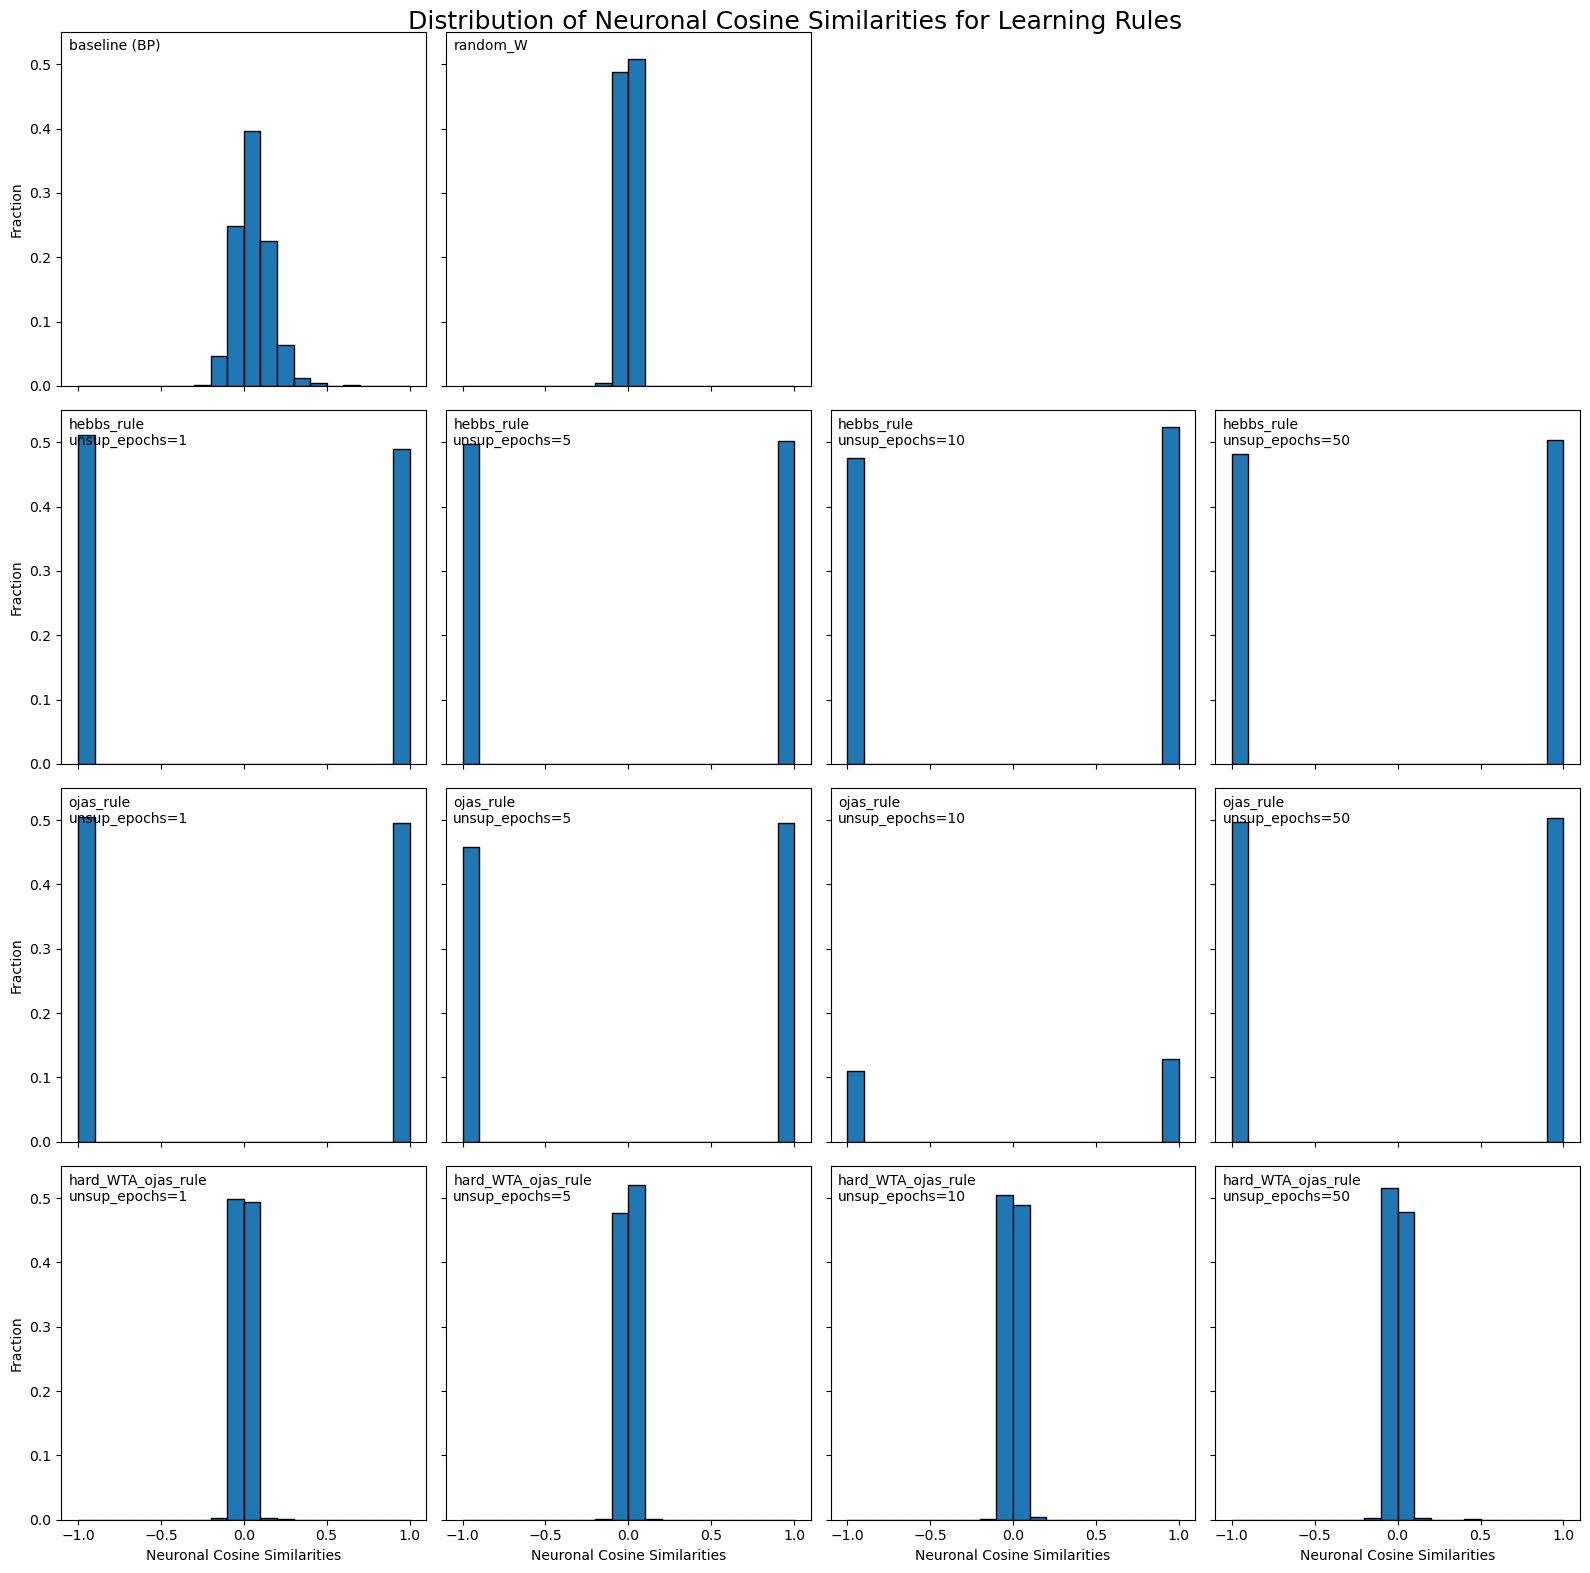

In [749]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)

# plot for baselines
axes[0, 0].hist(get_neuron_similarities(baseline), bins=20, range=(-1,1), weights=np.ones(num_samples)/num_samples, edgecolor='black')
axes[0, 1].hist(get_neuron_similarities(random_W), bins=20, range=(-1,1), weights=np.ones(num_samples)/num_samples, edgecolor='black')
axes[0, 0].text(0.02, 0.95, 'baseline (BP)', transform=axes[0, 0].transAxes)
axes[0, 1].text(0.02, 0.95, 'random_W', transform=axes[0, 1].transAxes)
axes[0, 2].axis('off')
axes[0, 3].axis('off')

# plot for Hebbian learning rules
for i, learning_rule in [(1, 'hebbs_rule'), (2, 'ojas_rule'), (3, 'hard_WTA_ojas_rule')]:
    for j, unsup_epochs in [(0, 1), (1, 5), (2, 10), (3, 50)]:
        ax = axes[i, j]
        model = load_model(learning_rule=learning_rule, unsup_epochs=unsup_epochs)
        ax.hist(get_neuron_similarities(model), bins=20, range=(-1,1), weights=np.ones(num_samples)/num_samples, edgecolor='black')
        ax.text(0.02, 0.9, f'{learning_rule}\nunsup_epochs={unsup_epochs}', transform=ax.transAxes)

# formatting
fig.suptitle('Distribution of Neuronal Cosine Similarities for Learning Rules', fontsize=18)
for j in range(4):
    axes[3, j].set_xlabel('Neuronal Cosine Similarities')
for i in range(4):
    axes[i, 0].set_ylabel('Fraction')
plt.tight_layout()
fig.savefig('figures/neuronal-similarities.png', dpi=300)

### Unsup synaptic activations in training

In [973]:
n_neurons=100
weights = []
learning_rule = 'hard_WTA_ojas_rule'
for epoch in range(1, 51):
    model = load_model(learning_rule=learning_rule, mid_training=True, epoch=epoch)
    weights.append(model.unsup_layer.W.flatten().detach().numpy()[:784*n_neurons])

plt.figure(figsize=(20, 5), dpi=300)
plt.pcolormesh(weights, cmap='Oranges')
for n in range(1, n_neurons):
    plt.axvline(n*784, c='cyan')
plt.colorbar()
plt.title("Ojas's Rule")
plt.tight_layout()
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/envs/hebbian/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/s1/tvdnvl8n0l52wc16d3x78qlw0000gn/T/ipykernel_2187/1648119173.py", line 5, in <module>
    model = load_model(learning_rule=learning_rule, mid_training=True, epoch=epoch)
  File "/var/folders/s1/tvdnvl8n0l52wc16d3x78qlw0000gn/T/ipykernel_2187/4284482658.py", line 9, in load_model
    model = GenHebb(28*28, 2000, 10, learning_rule)
  File "/Users/cutterdawes/Desktop/MPI/HebbianLearning/genhebb.py", line 72, in __init__
    self.unsup_layer = HebbianLayer(input_dim, hidden_dim, plasticity, wta, **kwargs)
  File "/Users/cutterdawes/Desktop/MPI/HebbianLearning/genhebb.py", line 34, in __init__
    self.learning_rule = LearningRule(plasticity, wta, **kwargs)
  File "/Users/cutterdawes/Desktop/MPI/HebbianLearning/learning_rules.py", line 100, in __init__
    self.

### Investigate learned features of baseline vs. Hebbian rules

In [1151]:
import random

In [1152]:
baseline = load_model(model_name='baseline-50_epochs-0.001_lr-64_batch')

In [1153]:
ojas_rule = load_model('ojas_rule', 'hard', 50)

In [1123]:
trainset = FastMNIST('./data', train=True, download=True)

In [1133]:
samples = {}
for image, label in trainset:
    if label.item() not in samples.keys():
        samples[label.item()] = image

In [1134]:
samples = dict(sorted(samples.items()))

In [1135]:
topk[0]

tensor([ 925, 1972,  540, 1354,  868, 1424,  995, 1253, 1719,  829])

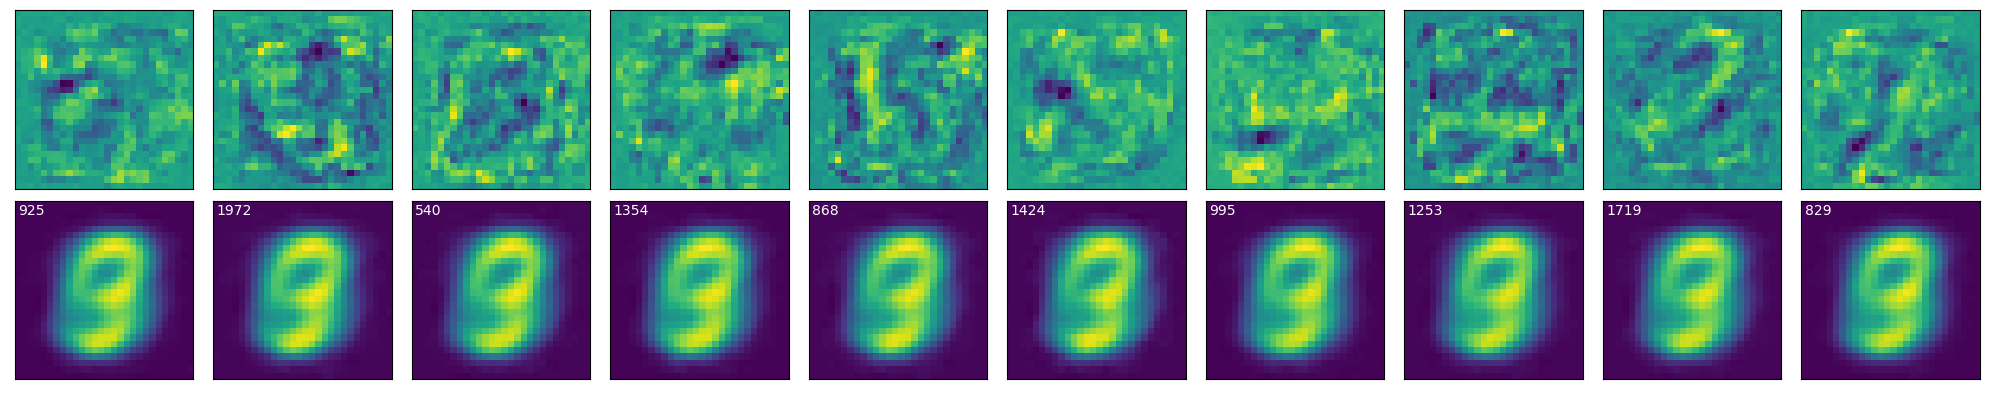

In [1140]:
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
_, topk = torch.topk(ojas_rule.hebb[0](samples[0].view(-1, 28*28)), 10)
for i in range(10):

    # get most activated hebbian neuron
    y_max = torch.argmax(ojas_rule.hebb[0](samples[i].view(-1, 28*28)))

    # plot baseline and hebbian learned weights
    axes[0,i].imshow(baseline.input.weight[i].view(28, 28).detach())
    axes[1,i].imshow(ojas_rule.hebb[0].W[topk.flatten()[i]].view(28, 28).detach())
    axes[1,i].text(0.02, 0.92, topk.flatten()[i].item(), transform=axes[1,i].transAxes, c='white')

    # formatting
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
plt.tight_layout()

In [12]:
from genhebb import HebbianLayer, GenHebb

In [13]:
def plot_weights(learning_rule, learning_params='none', unsup_epochs=10, unsup_lr=0.001):

    # parse model name
    directory = 'saved_models/done-training/'
    model_name = (
        f'genhebb-{learning_rule}-{learning_params}'
         '-100_hidden_dim-64_batch'
        f'-{unsup_epochs}_unsup_epochs-50_sup_epochs'
        f'-{unsup_lr}_unsup_lr-0.001_sup_lr'
    )
    path = directory + model_name + '.pt'

    # load model
    model = GenHebb(28*28, 100, 10, learning_rule)
    model.load_state_dict(torch.load(path))

    # plot weights
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(model.hebb[0].W[i].view(28, 28).detach(), cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(f'learning_rule={learning_rule}\nlearning_params={learning_params}', fontsize=14, y=0.96)
    plt.tight_layout()
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    fig.colorbar(im, ax=axes, cax=cbar_ax)
    fig.savefig(f'figures/weights-{learning_rule}-{learning_params}.png', dpi=300)

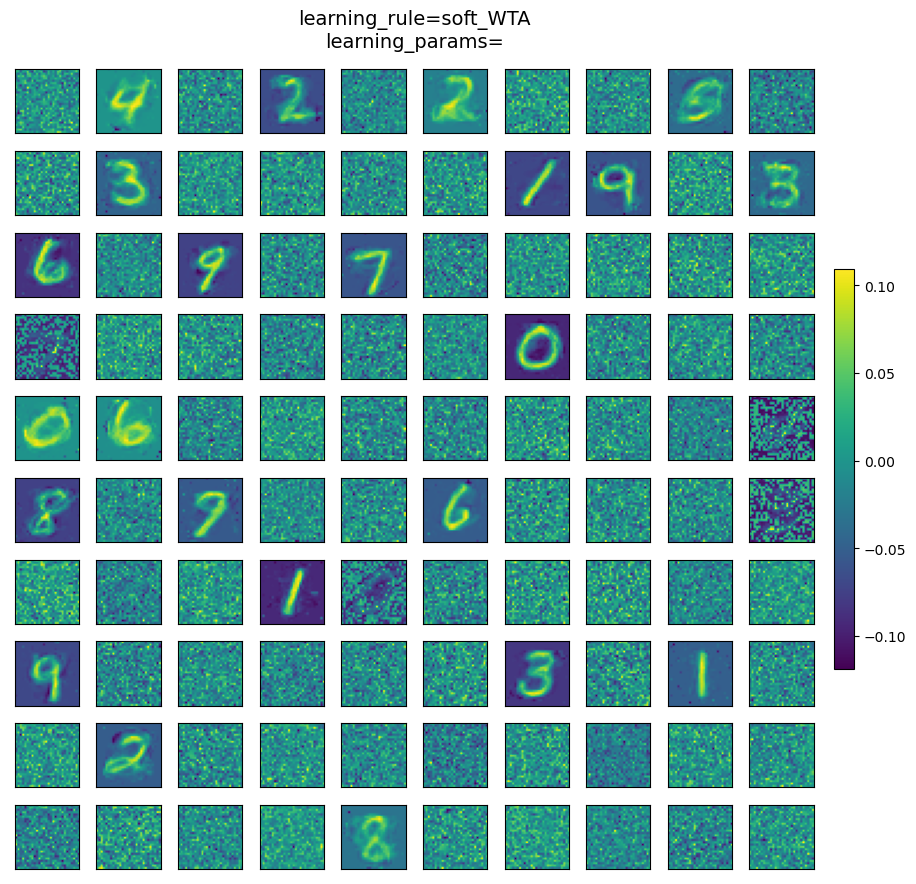

In [15]:
plot_weights('soft_WTA', '', 10, 0.03)

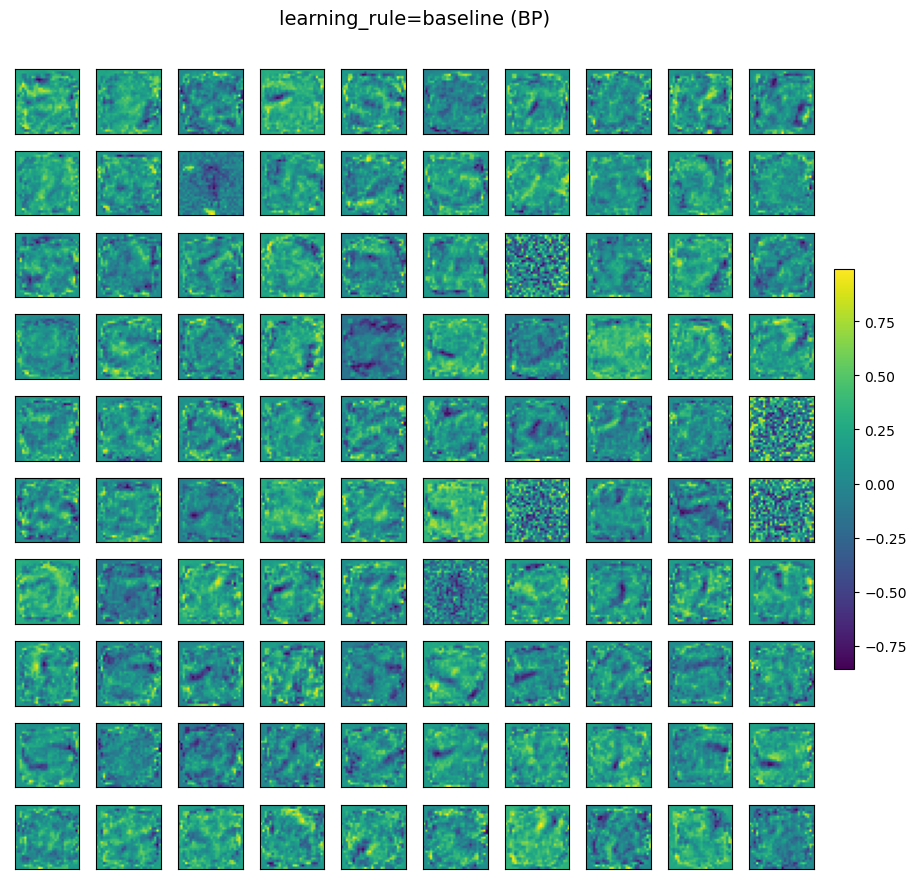

In [1292]:
# load model
path = 'saved_models/done-training/baseline-50_epochs-0.001_lr-64_batch.pt'
model = Baseline(28*28, 100, 10)
model.load_state_dict(torch.load(path))

# plot weights
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(model.input.weight[i].view(28, 28).detach(), cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle(f'learning_rule=baseline (BP)', fontsize=14, y=0.96)
plt.tight_layout()
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
fig.colorbar(im, ax=axes, cax=cbar_ax)
fig.savefig('figures/weights-baseline.png', dpi=300)

### Experiment with normalized anti-Hebbian update

In [1265]:
W = torch.randn(5, 3)
W = F.normalize(W)
x = torch.randn(3)
x = x / torch.norm(x)
y = torch.matmul(x, W.T)

In [1266]:
for i in range(40):
    dW = y.unsqueeze(-1) * x.unsqueeze(-2) + (y**2).unsqueeze(-1) * W.unsqueeze(0)
    W = W - dW
    print(torch.norm(W + dW))

tensor(2.2361)
tensor(1.6792)
tensor(2.1445)
tensor(2.4406)
tensor(2.5940)
tensor(2.6737)
tensor(2.7177)
tensor(2.7446)
tensor(2.7639)
tensor(2.7800)
tensor(2.7952)
tensor(2.8107)
tensor(2.8271)
tensor(2.8445)
tensor(2.8631)
tensor(2.8829)
tensor(2.9040)
tensor(2.9262)
tensor(2.9496)
tensor(2.9742)
tensor(2.9998)
tensor(3.0264)
tensor(3.0540)
tensor(3.0826)
tensor(3.1120)
tensor(3.1423)
tensor(3.1734)
tensor(3.2053)
tensor(3.2379)
tensor(3.2711)
tensor(3.3051)
tensor(3.3396)
tensor(3.3747)
tensor(3.4104)
tensor(3.4466)
tensor(3.4833)
tensor(3.5204)
tensor(3.5580)
tensor(3.5959)
tensor(3.6343)
